In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import sys
sys.path.insert(0, "../src")

# Model Architectures

In [5]:
import gc
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn import model_selection
from scipy.special import softmax
import albumentations as A

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn

import pretrainedmodels

import config
import dataset
import engine
import utils

## Data

In [6]:
# PSEUDO-LABELED DATA
df = pd.read_csv("../input/train.csv")
df.shape

(2048, 787)

In [7]:
# RUN ONCE
# SHUFFLE
df = df.sample(frac=1).reset_index(drop=True)

# MAKE FOLDS
kf = model_selection.StratifiedKFold(n_splits=5)
for fold, (train_indices, valid_indices) in enumerate(kf.split(df, y=df.digit)):
    np.save(f"../input/train_idx-fold{fold}-ver1", train_indices)
    np.save(f"../input/valid_idx-fold{fold}-ver1", valid_indices)

In [8]:
class EMNISTDataset(torch.utils.data.Dataset):
    def __init__(self, df, list_IDs, augs=None, label=True):
        self.list_IDs = list_IDs
        self.label = label
        self.images = df[config.PIXEL_COLS].values
        self.images = self.images.astype(np.uint8)
        self.images = self.images.reshape(-1, config.SIZE, config.SIZE, 1)

        if label:
            self.digits = df.digit.values

        if augs is None:
            self.augs = A.Compose([
                A.Normalize(config.MEAN, config.STD, max_pixel_value=255.0, always_apply=True,),
            ])
        else:
            self.augs = augs

    def __len__(self):
        return len(self.list_IDs)

    def __getitem__(self, item):
        # Get image
        index = self.list_IDs[item]
        image = self.images[index]

        # Augment image
        image = self.augs(image=image)["image"]

        # Convert to PyTorch tensor
        image = torch.tensor(image, dtype=torch.float)
        image = image.permute(2, 0, 1)
        
        # Convert to RGB channels
        image = image.repeat(3, 1, 1)

        # Get labels and return
        if self.label:
            digit = self.digits[index]
            digit = torch.tensor(digit, dtype=torch.long)
            return image, digit
        else:
            return image

## Model

### ResNet

In [9]:
def ResNet18(pretrained=None):
    model = pretrainedmodels.__dict__["resnet18"](pretrained=pretrained)
    in_feats = model.last_linear.in_features
    model.last_linear = nn.Linear(in_feats, 10)
    return model

def ResNet34(pretrained=None):
    model = pretrainedmodels.__dict__["resnet34"](pretrained=pretrained)
    in_feats = model.last_linear.in_features
    model.last_linear = nn.Linear(in_feats, 10)
    return model

def ResNet50(pretrained=None):
    model = pretrainedmodels.__dict__["resnet50"](pretrained=pretrained)
    in_feats = model.last_linear.in_features
    model.last_linear = nn.Linear(in_feats, 10)
    return model

def ResNet101(pretrained=None):
    model = pretrainedmodels.__dict__["resnet101"](pretrained=pretrained)
    in_feats = model.last_linear.in_features
    model.last_linear = nn.Linear(in_feats, 10)
    return model

def ResNet152(pretrained=None):
    model = pretrainedmodels.__dict__["resnet152"](pretrained=pretrained)
    in_feats = model.last_linear.in_features
    model.last_linear = nn.Linear(in_feats, 10)
    return model

### Efficientnet

In [10]:
def swish(x):
    return x * x.sigmoid()


def drop_connect(x, drop_ratio):
    keep_ratio = 1.0 - drop_ratio
    mask = torch.empty([x.shape[0], 1, 1, 1], dtype=x.dtype, device=x.device)
    mask.bernoulli_(keep_ratio)
    x.div_(keep_ratio)
    x.mul_(mask)
    return x


class SE(nn.Module):
    '''Squeeze-and-Excitation block with Swish.'''

    def __init__(self, in_channels, se_channels):
        super(SE, self).__init__()
        self.se1 = nn.Conv2d(in_channels, se_channels,
                             kernel_size=1, bias=True)
        self.se2 = nn.Conv2d(se_channels, in_channels,
                             kernel_size=1, bias=True)

    def forward(self, x):
        out = F.adaptive_avg_pool2d(x, (1, 1))
        out = swish(self.se1(out))
        out = self.se2(out).sigmoid()
        out = x * out
        return out


class Block(nn.Module):
    '''expansion + depthwise + pointwise + squeeze-excitation'''

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 expand_ratio=1,
                 se_ratio=0.,
                 drop_rate=0.):
        super(Block, self).__init__()
        self.stride = stride
        self.drop_rate = drop_rate
        self.expand_ratio = expand_ratio

        # Expansion
        channels = expand_ratio * in_channels
        self.conv1 = nn.Conv2d(in_channels,
                               channels,
                               kernel_size=1,
                               stride=1,
                               padding=0,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(channels)

        # Depthwise conv
        self.conv2 = nn.Conv2d(channels,
                               channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=(1 if kernel_size == 3 else 2),
                               groups=channels,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

        # SE layers
        se_channels = int(in_channels * se_ratio)
        self.se = SE(channels, se_channels)

        # Output
        self.conv3 = nn.Conv2d(channels,
                               out_channels,
                               kernel_size=1,
                               stride=1,
                               padding=0,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        # Skip connection if in and out shapes are the same (MV-V2 style)
        self.has_skip = (stride == 1) and (in_channels == out_channels)

    def forward(self, x):
        out = x if self.expand_ratio == 1 else swish(self.bn1(self.conv1(x)))
        out = swish(self.bn2(self.conv2(out)))
        out = self.se(out)
        out = self.bn3(self.conv3(out))
        if self.has_skip:
            if self.training and self.drop_rate > 0:
                out = drop_connect(out, self.drop_rate)
            out = out + x
        return out


class EfficientNet(nn.Module):
    def __init__(self, cfg, num_classes=10):
        super(EfficientNet, self).__init__()
        self.cfg = cfg
        self.conv1 = nn.Conv2d(3,
                               32,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_channels=32)
        self.linear = nn.Linear(cfg['out_channels'][-1], num_classes)

    def _make_layers(self, in_channels):
        layers = []
        cfg = [self.cfg[k] for k in ['expansion', 'out_channels', 'num_blocks', 'kernel_size',
                                     'stride']]
        b = 0
        blocks = sum(self.cfg['num_blocks'])
        for expansion, out_channels, num_blocks, kernel_size, stride in zip(*cfg):
            strides = [stride] + [1] * (num_blocks - 1)
            for stride in strides:
                drop_rate = self.cfg['drop_connect_rate'] * b / blocks
                layers.append(
                    Block(in_channels,
                          out_channels,
                          kernel_size,
                          stride,
                          expansion,
                          se_ratio=0.25,
                          drop_rate=drop_rate))
                in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = nn.ZeroPad2d(4)(x)
        
        out = swish(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        dropout_rate = self.cfg['dropout_rate']
        if self.training and dropout_rate > 0:
            out = F.dropout(out, p=dropout_rate)
        out = self.linear(out)
        return out


def EfficientNetB0():
    cfg = {
        'num_blocks': [1, 2, 2, 3, 3, 4, 1],
        'expansion': [1, 6, 6, 6, 6, 6, 6],
        'out_channels': [16, 24, 40, 80, 112, 192, 320],
        'kernel_size': [3, 3, 5, 3, 5, 5, 3],
        'stride': [1, 2, 2, 2, 1, 2, 1],
        'dropout_rate': 0.2,
        'drop_connect_rate': 0.2,
    }
    return EfficientNet(cfg)

### Wide ResNet

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)

def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_uniform_(m.weight, gain=np.sqrt(2))
        init.constant_(m.bias, 0)
    elif classname.find('BatchNorm') != -1:
        init.constant_(m.weight, 1)
        init.constant_(m.bias, 0)

class wide_basic(nn.Module):
    def __init__(self, in_planes, planes, dropout_rate, stride=1):
        super(wide_basic, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, bias=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=True),
            )

    def forward(self, x):
        out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(x)

        return out

class Wide_ResNet(nn.Module):
    def __init__(self, depth, widen_factor, dropout_rate, num_classes):
        super(Wide_ResNet, self).__init__()
        self.in_planes = 16

        assert ((depth-4)%6 ==0), 'Wide-resnet depth should be 6n+4'
        n = (depth-4)/6
        k = widen_factor

        print('| Wide-Resnet %dx%d' %(depth, k))
        nStages = [16, 16*k, 32*k, 64*k]

        # ADD PADDING
        self.pad = nn.ZeroPad2d(4)
        
        self.conv1 = conv3x3(3,nStages[0])
        self.layer1 = self._wide_layer(wide_basic, nStages[1], n, dropout_rate, stride=1)
        self.layer2 = self._wide_layer(wide_basic, nStages[2], n, dropout_rate, stride=2)
        self.layer3 = self._wide_layer(wide_basic, nStages[3], n, dropout_rate, stride=2)
        self.bn1 = nn.BatchNorm2d(nStages[3], momentum=0.9)
        self.linear = nn.Linear(nStages[3], num_classes)

    def _wide_layer(self, block, planes, num_blocks, dropout_rate, stride):
        strides = [stride] + [1]*(int(num_blocks)-1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, dropout_rate, stride))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        
        # ADD PADDING
        x = self.pad(x)
        
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

### DenseNet

In [8]:
def DenseNet121(pretrained=None):
    model = pretrainedmodels.__dict__["densenet121"](pretrained=pretrained)
    in_feats = model.last_linear.in_features
    model.last_linear = nn.Linear(in_feats, 10)
    return model

def DenseNet161(pretrained=None):
    model = pretrainedmodels.__dict__["densenet161"](pretrained=pretrained)
    in_feats = model.last_linear.in_features
    model.last_linear = nn.Linear(in_feats, 10)
    model.last_linear = nn.Linear(1024, 10)
    return model

def DenseNet169(pretrained=None):
    model = pretrainedmodels.__dict__["densenet169"](pretrained=pretrained)
    in_feats = model.last_linear.in_features
    model.last_linear = nn.Linear(in_feats, 10)
    return model

def DenseNet201(pretrained=None):
    model = pretrainedmodels.__dict__["densenet201"](pretrained=pretrained)
    in_feats = model.last_linear.in_features
    model.last_linear = nn.Linear(in_feats, 10)
    return model

###   Model Dispatcher

In [11]:
def get_model(model_name, pretrained=None):
    if model_name == "resnet18":
        return ResNet18(pretrained)
    elif model_name == "resnet34":
        return ResNet34(pretrained)
    elif model_name == "resnet50":
        return ResNet50(pretrained)
    elif model_name == "resnet101":
        return ResNet101(pretrained)
    elif model_name == "resnet152":
        return ResNet152(pretrained)
    elif model_name == "densenet121":
        return DenseNet121(pretrained)
    elif model_name == "densenet161":
        return DenseNet161(pretrained)
    elif model_name == "densenet169":
        return DenseNet169(pretrained)
    elif model_name == "densenet201":
        return DenseNet201(pretrained)
    elif model_name == "wideresnet28x10":
        return Wide_ResNet(28, 10, 0.3, 10)
    elif model_name == "efficientnet":
        return EfficientNetB0(pretrained)
    else:
        raise RuntimeError()

## Train

In [12]:
device = torch.device("cuda")
NUM_FOLDS = 5
MODEL_NAME = "resnet18"

### Wide ResNet

In [ ]:
oof = np.zeros((len(df), 10))

for fold in range(NUM_FOLDS):    
    train_indices = np.load(f"../input/train_idx-fold{fold}")
    valid_indices = np.load(f"../input/valid_idx-fold{fold}")
    train_ds = EMNISTDataset(df, train_indices)
    valid_ds = EMNISTDataset(df, valid_indices)
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4)
    valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=512)

    model = Wide_ResNet(28, 10, 0.3, 10)
    model.to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [60, 120, 160], gamma=0.2)
    scaler = torch.cuda.amp.GradScaler()

    swa_start = 150
    swa_model = AveragedModel(model).to(device)
    swa_scheduler = SWALR(optimizer, anneal_strategy="cos", anneal_epochs=5, swa_lr=8e-4)
    
    for epoch in range(200):
        engine.train(train_loader, model, optimizer, device, scaler, clip_grad=False)
        preds, targs = engine.evaluate(valid_loader, model, device)
        
        if epoch < swa_start:
            scheduler.step():
        else:
            swa_model.update_parameters(model)
            swa_sche

        preds = np.argmax(preds, axis=1)
        accuracy = metrics.accuracy_score(targs, preds)
        if i % 10 == 0:
            print(f"Epoch={epoch}, Accuracy={accuracy:.5f}")

    update_bn(train_loader, swa_model.cpu())
    preds, targs = engine.evaluate(valid_loader, swa_model.to(device), device)
    oof[valid_indices] = preds
    accuracy = metrics.accuracy_score(targs, np.argmax(preds, axis=1))
    print(f"Fold={fold}, Accuracy={accuracy}")
    
    torch.save(swa_model.state_dict(), f"../models/wide_resnet28x10-sgd-200eps-pl-swa-fold{fold}.pt")

    del model
    gc.collect()
    torch.cuda.empty_cache()
               
np.save(f"oof-wide_resnet28x10-swa", oof)

### Experiment Loop

In [ ]:
oof = np.zeros((len(df), 10))

for fold in range(NUM_FOLDS):
    # DATA
    train_indices = np.load(f"../input/train_idx-fold{fold}-ver1.npy")
    valid_indices = np.load(f"../input/valid_idx-fold{fold}-ver1.npy")
    train_ds = EMNISTDataset(df, train_indices)
    valid_ds = EMNISTDataset(df, valid_indices)
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4)
    valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=512)
    
    # MODEL and OPTIMIZER
    model = get_model(MODEL_NAME).to(device)
#     optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [150, 250], gamma=0.1)   
    scaler = torch.cuda.amp.GradScaler()
    
    # SWA
    swa_start = 270
    swa_model = AveragedModel(model).to(device)
    swa_scheduler = SWALR(optimizer, anneal_strategy="cos", anneal_epochs=5, swa_lr=1e-3)
    
    # TRAINING EPOCHS
    for epoch in range(350):
        engine.train(train_loader, model, optimizer, device, scaler, clip_grad=False)
        preds, targs = engine.evaluate(valid_loader, model, device)
        
        if epoch > swa_start:
            swa_model.update_parameters(model)
            swa_scheduler.step()
        else:
            scheduler.step()

        preds = np.argmax(preds, axis=1)
        accuracy = metrics.accuracy_score(targs, preds)
        if epoch % 10 == 0:
            print(f"Epoch={epoch}, Accuracy={accuracy:.5f}")

    # WARMUP BATCH STATISTICS
    update_bn(train_loader, swa_model.cpu())
    
    preds, targs = engine.evaluate(valid_loader, swa_model.to(device), device)
    oof[valid_indices] = preds
    accuracy = metrics.accuracy_score(targs, np.argmax(preds, axis=1))
    print(f"Fold={fold}, Accuracy={accuracy}")
    
    torch.save(swa_model.state_dict(), f"../models/{MODEL_NAME}-sgd-350eps-pl-swa-{fold}.pt")

    del model, swa_model
    gc.collect()
    torch.cuda.empty_cache()

np.save(f"./oof-{MODEL_NAME}-swa", oof)

Epoch=0, Accuracy=0.08780
Epoch=10, Accuracy=0.31707
Epoch=20, Accuracy=0.44146
Epoch=30, Accuracy=0.53902
Epoch=40, Accuracy=0.53415
Epoch=50, Accuracy=0.56341
Epoch=60, Accuracy=0.54634
Epoch=70, Accuracy=0.57561
Epoch=80, Accuracy=0.56341
Epoch=90, Accuracy=0.57317
Epoch=100, Accuracy=0.57317
Epoch=110, Accuracy=0.56829
Epoch=120, Accuracy=0.57805
Epoch=130, Accuracy=0.57805
Epoch=140, Accuracy=0.57561
Epoch=150, Accuracy=0.58293
Epoch=160, Accuracy=0.58780
Epoch=170, Accuracy=0.58780
Epoch=180, Accuracy=0.58293
Epoch=190, Accuracy=0.58537
Epoch=200, Accuracy=0.58780


In [12]:
oofb = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(df.digit.values, oofb)
print(f"CV accuracy score={accuracy}")

CV accuracy score=0.9421152285637003


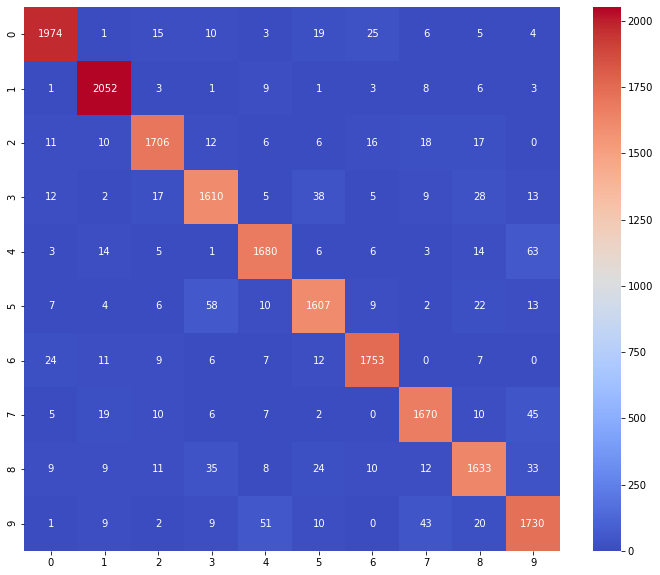

In [13]:
conf = metrics.confusion_matrix(df.digit, oofb)
plt.figure(figsize=(12, 10))
sns.heatmap(conf, cmap="coolwarm", annot=True, fmt="d");

### Post-processing

In [20]:
oof = np.load(f"./oof-{MODEL_NAME}-swa.npy")
oof = softmax(oof, axis=1)
oofb = np.argmax(oof, axis=1)

In [22]:
# Prior distribution of digits conditioned on letters
dists = joblib.load("../input/letter-to-digit-distribution.pkl")

for i, letter in enumerate(df.letter.values):
    oof[i] = oof[i] * dists[letter]
oofb = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(df.digit.values, oofb)
print(f"CV accuracy score with Post Process={accuracy}")

CV accuracy score with Post Process=0.9412496618880173


In [15]:
EXP = -0.9
s = pd.Series(oofb)
vc = s.value_counts().sort_index()
mat = np.diag(vc.astype("float32")**(EXP))

oofb = np.argmax(oof.dot(mat), axis=1)
accuracy = metrics.accuracy_score(df.digit.values, oofb)
print(f"CV accuracy score with Post Process={accuracy}")

CV accuracy score with Post Process=0.9416283473086287


## Test set inference

In [ ]:
df_test = pd.read_csv("../input/test.csv")
test_dataset = EMNISTDataset(df_test, np.arange(len(df_test)), label=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512)

### Blend

In [ ]:
preds_blend = np.zeros((len(df_test), 10))

for fold in range(5):
    model = get_model(MODEL_NAME)
    model = AveragedModel(model).to(device)
    model.load_state_dict(torch.load(f"../models/{MODEL_NAME}-sgd-350eps-pl-swa-{fold}.pt"))
    preds = engine.evaluate(test_loader, model, device, target=False)
    preds_blend += preds
    
np.save(f"./test-preds-{MODEL_NAME}-sgd-350eps-pl-swa", preds_blend)

In [ ]:
# POST-PROCESSING
# COULD SKIP
preds_blendb = np.argmax(preds_blend, axis=1)
s = pd.Series(preds_blend)
vc = s.value_counts().sort_index()
mat = np.diag(vc.astype("float32")**(EXP))
preds_blend = preds_blend.dot(mat)

In [ ]:
predsb = np.argmax(preds_blend, axis=1)
subm = pd.DataFrame({"id": df_test.id, "digit": predsb})
subm.to_csv(f"../output/{MODEL_NAME}-sgd-350eps-pl-swa-blend.csv", index=False)
subm.head()

### Vote

In [ ]:
preds_vote = np.zeros((5, len(df_test), 10))